In [1]:
import sys
sys.path.append("/home/jonas/phd/NanoNets/src/")
import model
import simulation
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import scienceplots
from scipy.optimize import curve_fit

In [2]:
def init_run(N):
    
    voltages                    = np.random.uniform(low=-0.3, high=0.3, size=(16,5))        
    topology_parameter          = {}
    topology_parameter["Np"]    = N
    topology_parameter["Nj"]    = 4
    topology_parameter["e_pos"] = [[-1.5,-1.5],[1.5,-1.5],[-1.5,1.5],[1.5,1.5]]
    sim_class                   = simulation.simulation(voltages)
    sim_class.init_random("",topology_parameter)

    

    sim_class.net_electrostatic.init_charge_vector(voltage_values=voltages[0])

    inv_capacitance_matrix  = sim_class.net_electrostatic.return_inv_capacitance_matrix()
    charge_vector           = sim_class.net_electrostatic.return_charge_vector()

    # Model
    net_model = model.model_class(net_topology=sim_class.net_topology, inv_capacitance_matrix=inv_capacitance_matrix)
    net_model.init_potential_vector(voltage_values=voltages[0])
    net_model.init_const_capacitance_values()

    # Return Model Arguments
    potential_vector                                                                        = net_model.return_potential_vector()
    const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2    = net_model.return_const_capacitance_values()
    N_electrodes, N_particles                                                               = net_model.return_particle_electrode_count()
    adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2, co_adv_index3             = net_model.return_advanced_indices()
    temperatures, temperatures_co                                                           = net_model.return_const_temperatures(T=0.28)
    resistances, resistances_co1, resistances_co2                                           = net_model.return_const_resistances()

    # Simulation Class
    summary = simulation.simulation_class(charge_vector, potential_vector, inv_capacitance_matrix, const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2,
                            temperatures, temperatures_co, resistances, resistances_co1, resistances_co2, adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2,
                            co_adv_index3, N_electrodes, N_particles)
    
    return summary

In [3]:
results = pd.DataFrame()
Ns      = np.arange(10,1001)
Nss     = []
times1  = []
times1s = []
times2  = []
times2s = []
times3  = []
times3s = []

for N in Ns:

    tt1 = []
    tt2 = []
    tt3 = []

    summary = init_run(N)
    summary.calc_potentials()
    
    for i in range(100000):
        
        random_number1  = np.random.rand()
        random_number2  = np.random.rand()
        if i > 90000:
            t1 = time.process_time_ns()

        summary.calc_tunnel_rates()
        # summary.calc_tunnel_rates_zero_T()
        if i > 90000:

            t2 = time.process_time_ns()

        summary.select_event(random_number1, random_number2)

        if i > 90000:
        
            t3 = time.process_time_ns()

            tt1.append(t2-t1)
            tt2.append(t3-t2)
            tt3.append(t3-t1)

    Nss.append(len(summary.tunnel_rates))
    times1.append(np.mean(tt1))
    times1s.append(np.std(tt1))

    times2.append(np.mean(tt2))
    times2s.append(np.std(tt2))

    times3.append(np.mean(tt3))
    times3s.append(np.std(tt3))

results['N']    = Nss
results['t1']   = times1
results['t1s']  = times1s
results['t2']   = times2
results['t2s']  = times2s
results['t3']   = times3
results['t3s']  = times3s

In [ ]:
def lin_scale(x, a, b):

    return a*(x-b) + b

def nlogn_scale(x, a, b):

    return a*(x*np.log(x)-b) + b

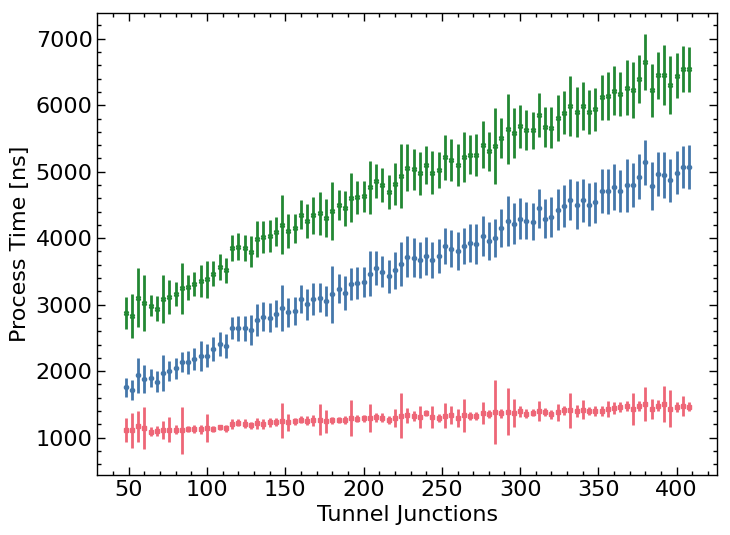

In [ ]:
with plt.style.context(["science","nature","bright","notebook"]):

    fig = plt.figure()
    ax  = fig.add_subplot()

    ax.errorbar(x=results['N'],y=results['t1'], yerr=results['t1s'], marker='o', ls='', label=f'Tunnel rates \n {var1}')
    ax.errorbar(x=results['N'],y=results['t2'], yerr=results['t2s'], marker='s', ls='', label=f'Select event \n {var2}')
    ax.errorbar(x=results['N'],y=results['t3'], yerr=results['t3s'], marker='X', ls='', label=f'Both \n {var3}')
    ax.set_xlabel('Tunnel Junctions')
    ax.set_ylabel('Process Time [ns]')
    ax.legend()
    # ax.set_yscale('log')

# ax.set_ylim(1000,200000)
# ax.set_yscale('log')

In [ ]:
var1 = np.var(np.log(results['t1']/results['N'])
var2 = np.var(np.log(results['t2']/results['N'])
var3 = np.var(np.log(results['t3']/results['N'])

(array([ 1.44615287e+00, -3.84451195e+03]),
 array([[4.08843477e-04, 4.68134905e+00],
        [4.68134905e+00, 5.45191909e+04]]))